In [2]:
# 随机模块
import random

# 绘图模块
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# numpy
import numpy as np
import pandas as pd

# pytorch
import torch
from torch import nn,optim
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.data import random_split
from torch.utils.tensorboard import SummaryWriter
from torch.nn import MSELoss
from torch.nn import CrossEntropyLoss as CEL
from torch.optim import lr_scheduler
import torchLearning
import datetime

# sklearn 
from sklearn.utils import shuffle

In [3]:
#数据预处理
def csv_to_tensor(csvDate):
    df = pd.read_csv(csvDate)
    data = shuffle(df, random_state=29)
    array = np.array(data)
    tensor = torch.tensor(array, dtype=torch.float32)
    return tensor



data = csv_to_tensor(r"C:\Users\Neos\Desktop\data\data_all.csv")

 
#等数据预处理 封装+加载
features = data[: ,:3]
labels_real = data[: ,3:6]
labels_fake = data[: ,6:9]

#dataset_real = TensorDataset(features, labels_real)

#dataset_fake = TensorDataset(features, labels_fake)

features_train = features[0:432,:]
features_test = features[432:,:]
labels_train = labels_real[0:432,:]
labels_test = labels_real[432:,:]

dataset_real_train = TensorDataset(features_train, labels_train)

dataset_real_test = TensorDataset(features_test, labels_test)

dataset_fake = TensorDataset(features, labels_fake)

#一般用torch.utils.data.dataset.random_split来获取训练集与测试集

#train_real, test_real = random_split(dataset_real,[432,108])
#train_real, test_real = random_split(dataset_real,[378,162])
#train_real, test_real = random_split(dataset_real,[270,270])
#train_real, test_real = random_split(dataset_real,[162,378])
#train_real, test_real = random_split(dataset_real,[108,432])


#一个batch里
batchdata_train_real = DataLoader(dataset_real_train, batch_size = 30, shuffle = True, drop_last = False)
batchdata_test_real = DataLoader(dataset_real_test, batch_size = 30, shuffle = True, drop_last = False)

#batchdata_train_real = DataLoader(train_real, batch_size = 30, shuffle = True, drop_last = False)
#batchdata_test_real = DataLoader(test_real, batch_size = 30, shuffle = True, drop_last = False)


batchdata_fake = DataLoader(dataset_fake, batch_size = 30, shuffle = True, drop_last = False)


#确定超参数
lr = 0.001
gamma = 0.9
bs = 30
lr_lambda = lambda epoch: 0.95 ** epoch

In [4]:
#定义神经网络模型
class Model_1(nn.Module):
    def __init__(self, in_features=3, out_features=3):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 24, bias = True)
        self.output = nn.Linear(24, out_features, bias = True)
         
    def forward(self, x): #神经网络的向前传播
        #定义一个LeakyReLU
        m = nn.LeakyReLU(0.1) 
        z1 = self.linear1(x)
        p1 = m(z1)
        yhat = self.output(p1)
        return yhat

In [5]:
#定义神经网络模型
class Model_2(nn.Module):
    def __init__(self, in_features=3, out_features=3):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 24, bias = True)
        self.output = nn.Linear(24, out_features, bias = True)
         
    def forward(self, x): #神经网络的向前传播
        #定义一个LeakyReLU
        m = nn.LeakyReLU(0.1) 
        z1 = self.linear1(x)
        p1 = m(z1)
        yhat = self.output(p1)
        return yhat

In [6]:
#定义训练函数1，其中包括损失函数，优化算法，梯度下降流程等等
def fit_1(net, batchdata, lr=0.001, epochs=20, gamma =0.9, betas=(0.9, 0.99)):
    
    criterion = MSELoss()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr, betas=betas, eps=1e-08, weight_decay=0, amsgrad=False)

    # 创建学习率调度器
    scheduler = lr_scheduler.LambdaLR(opt, lr_lambda)
    
    lr_l = [lr]
    
    for epoch in range(epochs):
        for x,y in batchdata:
            yhat = net.forward(x)
            loss = criterion(yhat, y)
            loss.backward()
            opt.step()
            #梯度清零两者皆可
            #net.zero_grad()
            opt.zero_grad()
        
        scheduler.step()
        print(loss)

In [7]:
#实例化神经网络
# 设置随机数种子
torch.manual_seed(420)

#用于直接训练real_data
net_1 = Model_1(in_features=3, out_features=3)

#用于先训练fake_data，再训练real_data
net_2 = Model_2(in_features=3, out_features=3)

In [8]:
def mse_cal(data_loader, net):
    """mse计算函数
    
    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MSE计算结果
    """
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    return F.mse_loss(yhat, y)

def rmse_cal(data_loader, net):
    """rmse计算函数
    
    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MSE计算结果
    """
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    mse = F.mse_loss(yhat, y)
    rmse= np.sqrt(mse.detach())
    return rmse

def mae_cal(data_loader, net):
    """mae计算函数
    
    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MAE计算结果
    """
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    mae_loss = nn.L1Loss(reduction = 'mean')
    #mae_loss = nn.L1Loss(reduce = 'mean')
    return mae_loss(yhat, y)

def r2_cal(data_loader, net):
    """mae计算函数
    
    :param data_loader：加载好的数据
    :param net: 模型
    :return：根据输入的数据，输出其MAE计算结果
    """
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    SS_res = torch.sum(torch.square(y - yhat))
    SS_tot = torch.sum(torch.square(y - torch.mean(y)))
    r2 = 1 - SS_res / SS_tot
    return r2

def model_train_test(model, 
                     train_data,
                     test_data,
                     num_epochs = 20):
    """模型误差测试函数：
    :param model_l：模型
    :param train_data：训练数据
    :param test_data: 测试数据   
    :param num_epochs：迭代轮数
    :param criterion: 损失函数
    :return：MSE列表
    """  
    # 模型评估指标矩阵
    rmse_train = []
    rmse_test = []
    mse_train = []
    mse_test = []
    mae_train = []
    mae_test = []
    r2_train = []
    r2_test = []
    eva_train = []
    eva_test = []
    # 模型训练过程
    for epochs in range(num_epochs):
        model.train()
        fit_1(net = model,
            batchdata = train_data, 
            epochs = epochs)
        model.eval()
        rmse_train.append(rmse_cal(train_data, model).detach().item())
        rmse_test.append(rmse_cal(test_data, model).detach().item())
        mse_train.append(mse_cal(train_data, model).detach().item())
        mse_test.append(mse_cal(test_data, model).detach().item())
        mae_train.append(mae_cal(train_data, model).detach().item())
        mae_test.append(mae_cal(test_data, model).detach().item())
        r2_train.append(r2_cal(train_data, model).detach().item())
        r2_test.append(r2_cal(test_data, model).detach().item())
    
    eva_train.append(rmse_train)
    eva_train.append(mse_train)
    eva_train.append(mae_train)
    eva_train.append(r2_train)
    
    eva_test.append(rmse_test)
    eva_test.append(mse_test)
    eva_test.append(mae_test)
    eva_test.append(r2_test)
    
    return eva_train,eva_test

In [7]:
#直接用real_data训练net_1
starttime = datetime.datetime.now()

for i in range(150):
    fit_1(net_1, batchdata_train_real, epochs = 20)

endtime = datetime.datetime.now()
print(endtime - starttime)

tensor(2314.2739, grad_fn=<MseLossBackward0>)
tensor(408.0034, grad_fn=<MseLossBackward0>)
tensor(476.6502, grad_fn=<MseLossBackward0>)
tensor(200.0369, grad_fn=<MseLossBackward0>)
tensor(241.1802, grad_fn=<MseLossBackward0>)
tensor(186.5589, grad_fn=<MseLossBackward0>)
tensor(131.1020, grad_fn=<MseLossBackward0>)
tensor(150.1232, grad_fn=<MseLossBackward0>)
tensor(170.6363, grad_fn=<MseLossBackward0>)
tensor(84.7880, grad_fn=<MseLossBackward0>)
tensor(86.7859, grad_fn=<MseLossBackward0>)
tensor(79.0445, grad_fn=<MseLossBackward0>)
tensor(90.1533, grad_fn=<MseLossBackward0>)
tensor(65.9920, grad_fn=<MseLossBackward0>)
tensor(70.2009, grad_fn=<MseLossBackward0>)
tensor(84.1317, grad_fn=<MseLossBackward0>)
tensor(87.5481, grad_fn=<MseLossBackward0>)
tensor(94.4227, grad_fn=<MseLossBackward0>)
tensor(96.5433, grad_fn=<MseLossBackward0>)
tensor(74.9683, grad_fn=<MseLossBackward0>)
tensor(53.3831, grad_fn=<MseLossBackward0>)
tensor(116.3382, grad_fn=<MseLossBackward0>)
tensor(126.8497, grad

tensor(17.8332, grad_fn=<MseLossBackward0>)
tensor(27.2309, grad_fn=<MseLossBackward0>)
tensor(38.8674, grad_fn=<MseLossBackward0>)
tensor(13.7681, grad_fn=<MseLossBackward0>)
tensor(21.6561, grad_fn=<MseLossBackward0>)
tensor(33.9664, grad_fn=<MseLossBackward0>)
tensor(13.6629, grad_fn=<MseLossBackward0>)
tensor(41.0808, grad_fn=<MseLossBackward0>)
tensor(17.7022, grad_fn=<MseLossBackward0>)
tensor(47.2671, grad_fn=<MseLossBackward0>)
tensor(55.6341, grad_fn=<MseLossBackward0>)
tensor(52.0418, grad_fn=<MseLossBackward0>)
tensor(46.0633, grad_fn=<MseLossBackward0>)
tensor(37.4691, grad_fn=<MseLossBackward0>)
tensor(26.4346, grad_fn=<MseLossBackward0>)
tensor(40.6793, grad_fn=<MseLossBackward0>)
tensor(21.9668, grad_fn=<MseLossBackward0>)
tensor(49.4146, grad_fn=<MseLossBackward0>)
tensor(43.7467, grad_fn=<MseLossBackward0>)
tensor(31.5952, grad_fn=<MseLossBackward0>)
tensor(26.1021, grad_fn=<MseLossBackward0>)
tensor(23.9886, grad_fn=<MseLossBackward0>)
tensor(28.6928, grad_fn=<MseLoss

tensor(23.6807, grad_fn=<MseLossBackward0>)
tensor(12.3967, grad_fn=<MseLossBackward0>)
tensor(37.1057, grad_fn=<MseLossBackward0>)
tensor(35.0216, grad_fn=<MseLossBackward0>)
tensor(24.4136, grad_fn=<MseLossBackward0>)
tensor(24.0309, grad_fn=<MseLossBackward0>)
tensor(8.1214, grad_fn=<MseLossBackward0>)
tensor(18.3179, grad_fn=<MseLossBackward0>)
tensor(21.2791, grad_fn=<MseLossBackward0>)
tensor(22.4638, grad_fn=<MseLossBackward0>)
tensor(26.7995, grad_fn=<MseLossBackward0>)
tensor(10.8917, grad_fn=<MseLossBackward0>)
tensor(23.8842, grad_fn=<MseLossBackward0>)
tensor(8.5071, grad_fn=<MseLossBackward0>)
tensor(19.8652, grad_fn=<MseLossBackward0>)
tensor(13.9851, grad_fn=<MseLossBackward0>)
tensor(29.8534, grad_fn=<MseLossBackward0>)
tensor(25.5112, grad_fn=<MseLossBackward0>)
tensor(15.4798, grad_fn=<MseLossBackward0>)
tensor(26.3017, grad_fn=<MseLossBackward0>)
tensor(41.7650, grad_fn=<MseLossBackward0>)
tensor(30.5468, grad_fn=<MseLossBackward0>)
tensor(10.1370, grad_fn=<MseLossBa

tensor(20.9197, grad_fn=<MseLossBackward0>)
tensor(8.4655, grad_fn=<MseLossBackward0>)
tensor(9.2976, grad_fn=<MseLossBackward0>)
tensor(15.4388, grad_fn=<MseLossBackward0>)
tensor(10.1202, grad_fn=<MseLossBackward0>)
tensor(24.7846, grad_fn=<MseLossBackward0>)
tensor(21.1441, grad_fn=<MseLossBackward0>)
tensor(8.5881, grad_fn=<MseLossBackward0>)
tensor(12.3590, grad_fn=<MseLossBackward0>)
tensor(6.1044, grad_fn=<MseLossBackward0>)
tensor(7.4818, grad_fn=<MseLossBackward0>)
tensor(22.0508, grad_fn=<MseLossBackward0>)
tensor(15.4919, grad_fn=<MseLossBackward0>)
tensor(15.0943, grad_fn=<MseLossBackward0>)
tensor(11.7455, grad_fn=<MseLossBackward0>)
tensor(22.7812, grad_fn=<MseLossBackward0>)
tensor(17.0582, grad_fn=<MseLossBackward0>)
tensor(8.8854, grad_fn=<MseLossBackward0>)
tensor(18.1200, grad_fn=<MseLossBackward0>)
tensor(6.1239, grad_fn=<MseLossBackward0>)
tensor(10.5289, grad_fn=<MseLossBackward0>)
tensor(16.7207, grad_fn=<MseLossBackward0>)
tensor(18.8693, grad_fn=<MseLossBackwar

tensor(12.4754, grad_fn=<MseLossBackward0>)
tensor(7.9503, grad_fn=<MseLossBackward0>)
tensor(4.4089, grad_fn=<MseLossBackward0>)
tensor(8.9293, grad_fn=<MseLossBackward0>)
tensor(9.3563, grad_fn=<MseLossBackward0>)
tensor(8.4593, grad_fn=<MseLossBackward0>)
tensor(6.6346, grad_fn=<MseLossBackward0>)
tensor(15.1570, grad_fn=<MseLossBackward0>)
tensor(8.6373, grad_fn=<MseLossBackward0>)
tensor(10.6389, grad_fn=<MseLossBackward0>)
tensor(13.0006, grad_fn=<MseLossBackward0>)
tensor(15.4632, grad_fn=<MseLossBackward0>)
tensor(4.5200, grad_fn=<MseLossBackward0>)
tensor(2.4183, grad_fn=<MseLossBackward0>)
tensor(16.3432, grad_fn=<MseLossBackward0>)
tensor(8.2364, grad_fn=<MseLossBackward0>)
tensor(11.9956, grad_fn=<MseLossBackward0>)
tensor(3.3271, grad_fn=<MseLossBackward0>)
tensor(12.8859, grad_fn=<MseLossBackward0>)
tensor(11.4573, grad_fn=<MseLossBackward0>)
tensor(7.8337, grad_fn=<MseLossBackward0>)
tensor(8.7721, grad_fn=<MseLossBackward0>)
tensor(9.4015, grad_fn=<MseLossBackward0>)
te

tensor(3.6293, grad_fn=<MseLossBackward0>)
tensor(6.2294, grad_fn=<MseLossBackward0>)
tensor(6.5388, grad_fn=<MseLossBackward0>)
tensor(7.2670, grad_fn=<MseLossBackward0>)
tensor(4.4529, grad_fn=<MseLossBackward0>)
tensor(2.2295, grad_fn=<MseLossBackward0>)
tensor(3.9322, grad_fn=<MseLossBackward0>)
tensor(2.5837, grad_fn=<MseLossBackward0>)
tensor(3.9018, grad_fn=<MseLossBackward0>)
tensor(5.5708, grad_fn=<MseLossBackward0>)
tensor(6.9959, grad_fn=<MseLossBackward0>)
tensor(2.7290, grad_fn=<MseLossBackward0>)
tensor(2.4562, grad_fn=<MseLossBackward0>)
tensor(5.9464, grad_fn=<MseLossBackward0>)
tensor(3.0824, grad_fn=<MseLossBackward0>)
tensor(3.9581, grad_fn=<MseLossBackward0>)
tensor(4.0452, grad_fn=<MseLossBackward0>)
tensor(5.5592, grad_fn=<MseLossBackward0>)
tensor(3.2841, grad_fn=<MseLossBackward0>)
tensor(5.7656, grad_fn=<MseLossBackward0>)
tensor(4.5250, grad_fn=<MseLossBackward0>)
tensor(12.7628, grad_fn=<MseLossBackward0>)
tensor(4.4847, grad_fn=<MseLossBackward0>)
tensor(5.2

tensor(3.9847, grad_fn=<MseLossBackward0>)
tensor(3.8777, grad_fn=<MseLossBackward0>)
tensor(8.7612, grad_fn=<MseLossBackward0>)
tensor(2.5604, grad_fn=<MseLossBackward0>)
tensor(2.7776, grad_fn=<MseLossBackward0>)
tensor(1.1739, grad_fn=<MseLossBackward0>)
tensor(1.8939, grad_fn=<MseLossBackward0>)
tensor(2.3636, grad_fn=<MseLossBackward0>)
tensor(1.9728, grad_fn=<MseLossBackward0>)
tensor(2.2387, grad_fn=<MseLossBackward0>)
tensor(2.4204, grad_fn=<MseLossBackward0>)
tensor(1.4665, grad_fn=<MseLossBackward0>)
tensor(2.5570, grad_fn=<MseLossBackward0>)
tensor(2.9613, grad_fn=<MseLossBackward0>)
tensor(1.7655, grad_fn=<MseLossBackward0>)
tensor(2.6548, grad_fn=<MseLossBackward0>)
tensor(2.4740, grad_fn=<MseLossBackward0>)
tensor(1.1261, grad_fn=<MseLossBackward0>)
tensor(1.6771, grad_fn=<MseLossBackward0>)
tensor(0.7579, grad_fn=<MseLossBackward0>)
tensor(1.7231, grad_fn=<MseLossBackward0>)
tensor(1.0728, grad_fn=<MseLossBackward0>)
tensor(3.1626, grad_fn=<MseLossBackward0>)
tensor(3.15

tensor(3.3712, grad_fn=<MseLossBackward0>)
tensor(1.7946, grad_fn=<MseLossBackward0>)
tensor(1.1258, grad_fn=<MseLossBackward0>)
tensor(0.9072, grad_fn=<MseLossBackward0>)
tensor(0.5531, grad_fn=<MseLossBackward0>)
tensor(0.7445, grad_fn=<MseLossBackward0>)
tensor(1.1645, grad_fn=<MseLossBackward0>)
tensor(0.7729, grad_fn=<MseLossBackward0>)
tensor(0.5866, grad_fn=<MseLossBackward0>)
tensor(0.2742, grad_fn=<MseLossBackward0>)
tensor(0.5070, grad_fn=<MseLossBackward0>)
tensor(0.3018, grad_fn=<MseLossBackward0>)
tensor(0.8085, grad_fn=<MseLossBackward0>)
tensor(0.4098, grad_fn=<MseLossBackward0>)
tensor(0.6909, grad_fn=<MseLossBackward0>)
tensor(0.4171, grad_fn=<MseLossBackward0>)
tensor(0.5453, grad_fn=<MseLossBackward0>)
tensor(0.7220, grad_fn=<MseLossBackward0>)
tensor(0.3985, grad_fn=<MseLossBackward0>)
tensor(0.7008, grad_fn=<MseLossBackward0>)
tensor(4.6754, grad_fn=<MseLossBackward0>)
tensor(0.7019, grad_fn=<MseLossBackward0>)
tensor(1.3717, grad_fn=<MseLossBackward0>)
tensor(0.66

tensor(0.2624, grad_fn=<MseLossBackward0>)
tensor(0.2148, grad_fn=<MseLossBackward0>)
tensor(0.1381, grad_fn=<MseLossBackward0>)
tensor(0.3419, grad_fn=<MseLossBackward0>)
tensor(1.9187, grad_fn=<MseLossBackward0>)
tensor(2.0194, grad_fn=<MseLossBackward0>)
tensor(0.2602, grad_fn=<MseLossBackward0>)
tensor(0.7279, grad_fn=<MseLossBackward0>)
tensor(0.1650, grad_fn=<MseLossBackward0>)
tensor(0.2080, grad_fn=<MseLossBackward0>)
tensor(0.1470, grad_fn=<MseLossBackward0>)
tensor(0.2085, grad_fn=<MseLossBackward0>)
tensor(0.0796, grad_fn=<MseLossBackward0>)
tensor(0.2159, grad_fn=<MseLossBackward0>)
tensor(0.2755, grad_fn=<MseLossBackward0>)
tensor(0.2715, grad_fn=<MseLossBackward0>)
tensor(0.2736, grad_fn=<MseLossBackward0>)
tensor(0.2766, grad_fn=<MseLossBackward0>)
tensor(0.1785, grad_fn=<MseLossBackward0>)
tensor(0.1604, grad_fn=<MseLossBackward0>)
tensor(0.1533, grad_fn=<MseLossBackward0>)
tensor(0.1473, grad_fn=<MseLossBackward0>)
tensor(0.1855, grad_fn=<MseLossBackward0>)
tensor(0.28

tensor(0.0936, grad_fn=<MseLossBackward0>)
tensor(0.1174, grad_fn=<MseLossBackward0>)
tensor(0.1399, grad_fn=<MseLossBackward0>)
tensor(0.1633, grad_fn=<MseLossBackward0>)
tensor(0.1827, grad_fn=<MseLossBackward0>)
tensor(0.2990, grad_fn=<MseLossBackward0>)
tensor(0.1416, grad_fn=<MseLossBackward0>)
tensor(0.1070, grad_fn=<MseLossBackward0>)
tensor(0.0662, grad_fn=<MseLossBackward0>)
tensor(0.0611, grad_fn=<MseLossBackward0>)
tensor(0.0843, grad_fn=<MseLossBackward0>)
tensor(5.5472, grad_fn=<MseLossBackward0>)
tensor(1.8049, grad_fn=<MseLossBackward0>)
tensor(0.4785, grad_fn=<MseLossBackward0>)
tensor(0.0702, grad_fn=<MseLossBackward0>)
tensor(0.0747, grad_fn=<MseLossBackward0>)
tensor(0.1159, grad_fn=<MseLossBackward0>)
tensor(0.1060, grad_fn=<MseLossBackward0>)
tensor(0.1593, grad_fn=<MseLossBackward0>)
tensor(0.1621, grad_fn=<MseLossBackward0>)
tensor(0.2016, grad_fn=<MseLossBackward0>)
tensor(0.1217, grad_fn=<MseLossBackward0>)
tensor(0.1392, grad_fn=<MseLossBackward0>)
tensor(0.15

tensor(0.1127, grad_fn=<MseLossBackward0>)
tensor(0.0647, grad_fn=<MseLossBackward0>)
tensor(0.0636, grad_fn=<MseLossBackward0>)
tensor(0.0800, grad_fn=<MseLossBackward0>)
tensor(0.1920, grad_fn=<MseLossBackward0>)
tensor(0.1206, grad_fn=<MseLossBackward0>)
tensor(0.0965, grad_fn=<MseLossBackward0>)
tensor(0.0702, grad_fn=<MseLossBackward0>)
tensor(0.0947, grad_fn=<MseLossBackward0>)
tensor(0.0755, grad_fn=<MseLossBackward0>)
tensor(0.0682, grad_fn=<MseLossBackward0>)
tensor(0.0418, grad_fn=<MseLossBackward0>)
tensor(0.0901, grad_fn=<MseLossBackward0>)
tensor(0.0796, grad_fn=<MseLossBackward0>)
tensor(1.7776, grad_fn=<MseLossBackward0>)
tensor(3.5739, grad_fn=<MseLossBackward0>)
tensor(0.4913, grad_fn=<MseLossBackward0>)
tensor(0.0806, grad_fn=<MseLossBackward0>)
tensor(0.0455, grad_fn=<MseLossBackward0>)
tensor(0.0455, grad_fn=<MseLossBackward0>)
tensor(0.0552, grad_fn=<MseLossBackward0>)
tensor(0.7497, grad_fn=<MseLossBackward0>)
tensor(0.1107, grad_fn=<MseLossBackward0>)
tensor(0.10

tensor(0.0548, grad_fn=<MseLossBackward0>)
tensor(0.0554, grad_fn=<MseLossBackward0>)
tensor(0.0925, grad_fn=<MseLossBackward0>)
tensor(0.0330, grad_fn=<MseLossBackward0>)
tensor(0.0901, grad_fn=<MseLossBackward0>)
tensor(0.0856, grad_fn=<MseLossBackward0>)
tensor(0.1068, grad_fn=<MseLossBackward0>)
tensor(0.0296, grad_fn=<MseLossBackward0>)
tensor(0.0308, grad_fn=<MseLossBackward0>)
tensor(0.0754, grad_fn=<MseLossBackward0>)
tensor(0.0591, grad_fn=<MseLossBackward0>)
tensor(0.1162, grad_fn=<MseLossBackward0>)
tensor(0.1862, grad_fn=<MseLossBackward0>)
tensor(0.1068, grad_fn=<MseLossBackward0>)
tensor(0.1583, grad_fn=<MseLossBackward0>)
tensor(0.1909, grad_fn=<MseLossBackward0>)
tensor(0.1219, grad_fn=<MseLossBackward0>)
tensor(5.0509, grad_fn=<MseLossBackward0>)
tensor(0.5679, grad_fn=<MseLossBackward0>)
tensor(0.5032, grad_fn=<MseLossBackward0>)
tensor(0.1761, grad_fn=<MseLossBackward0>)
tensor(0.0635, grad_fn=<MseLossBackward0>)
tensor(0.0758, grad_fn=<MseLossBackward0>)
tensor(0.16

tensor(0.0995, grad_fn=<MseLossBackward0>)
tensor(0.1039, grad_fn=<MseLossBackward0>)
tensor(0.0775, grad_fn=<MseLossBackward0>)
tensor(0.0875, grad_fn=<MseLossBackward0>)
tensor(9.7586, grad_fn=<MseLossBackward0>)
tensor(1.9774, grad_fn=<MseLossBackward0>)
tensor(0.4738, grad_fn=<MseLossBackward0>)
tensor(0.0144, grad_fn=<MseLossBackward0>)
tensor(0.0315, grad_fn=<MseLossBackward0>)
tensor(0.0662, grad_fn=<MseLossBackward0>)
tensor(0.1174, grad_fn=<MseLossBackward0>)
tensor(0.1123, grad_fn=<MseLossBackward0>)
tensor(0.0420, grad_fn=<MseLossBackward0>)
tensor(0.0595, grad_fn=<MseLossBackward0>)
tensor(0.0331, grad_fn=<MseLossBackward0>)
tensor(0.0607, grad_fn=<MseLossBackward0>)
tensor(0.0604, grad_fn=<MseLossBackward0>)
tensor(0.1426, grad_fn=<MseLossBackward0>)
tensor(0.0436, grad_fn=<MseLossBackward0>)
tensor(0.1356, grad_fn=<MseLossBackward0>)
tensor(0.1335, grad_fn=<MseLossBackward0>)
tensor(0.0774, grad_fn=<MseLossBackward0>)
tensor(0.0540, grad_fn=<MseLossBackward0>)
tensor(0.07

tensor(0.0383, grad_fn=<MseLossBackward0>)
tensor(0.1012, grad_fn=<MseLossBackward0>)
tensor(0.0639, grad_fn=<MseLossBackward0>)
tensor(0.0567, grad_fn=<MseLossBackward0>)
tensor(0.0438, grad_fn=<MseLossBackward0>)
tensor(0.0891, grad_fn=<MseLossBackward0>)
tensor(0.0408, grad_fn=<MseLossBackward0>)
tensor(0.1726, grad_fn=<MseLossBackward0>)
tensor(3.9858, grad_fn=<MseLossBackward0>)
tensor(0.1790, grad_fn=<MseLossBackward0>)
tensor(0.3859, grad_fn=<MseLossBackward0>)
tensor(0.0848, grad_fn=<MseLossBackward0>)
tensor(0.0755, grad_fn=<MseLossBackward0>)
tensor(0.1013, grad_fn=<MseLossBackward0>)
tensor(0.1596, grad_fn=<MseLossBackward0>)
tensor(0.0628, grad_fn=<MseLossBackward0>)
tensor(0.0752, grad_fn=<MseLossBackward0>)
tensor(0.0939, grad_fn=<MseLossBackward0>)
tensor(0.0769, grad_fn=<MseLossBackward0>)
tensor(0.0554, grad_fn=<MseLossBackward0>)
tensor(0.1105, grad_fn=<MseLossBackward0>)
tensor(0.0990, grad_fn=<MseLossBackward0>)
tensor(0.0690, grad_fn=<MseLossBackward0>)
tensor(0.09

tensor(0.0412, grad_fn=<MseLossBackward0>)
tensor(0.0755, grad_fn=<MseLossBackward0>)
tensor(0.0897, grad_fn=<MseLossBackward0>)
tensor(0.0477, grad_fn=<MseLossBackward0>)
tensor(0.0526, grad_fn=<MseLossBackward0>)
tensor(0.0148, grad_fn=<MseLossBackward0>)
tensor(0.1009, grad_fn=<MseLossBackward0>)
tensor(0.0508, grad_fn=<MseLossBackward0>)
tensor(0.0858, grad_fn=<MseLossBackward0>)
tensor(0.1096, grad_fn=<MseLossBackward0>)
tensor(0.1347, grad_fn=<MseLossBackward0>)
tensor(0.0666, grad_fn=<MseLossBackward0>)
tensor(0.1219, grad_fn=<MseLossBackward0>)
tensor(0.0647, grad_fn=<MseLossBackward0>)
tensor(2.6807, grad_fn=<MseLossBackward0>)
tensor(0.5151, grad_fn=<MseLossBackward0>)
tensor(0.3660, grad_fn=<MseLossBackward0>)
tensor(0.1318, grad_fn=<MseLossBackward0>)
tensor(0.0744, grad_fn=<MseLossBackward0>)
tensor(0.0497, grad_fn=<MseLossBackward0>)
tensor(0.0399, grad_fn=<MseLossBackward0>)
tensor(0.0596, grad_fn=<MseLossBackward0>)
tensor(0.0681, grad_fn=<MseLossBackward0>)
tensor(0.04

tensor(0.1011, grad_fn=<MseLossBackward0>)
tensor(0.0673, grad_fn=<MseLossBackward0>)
tensor(0.0994, grad_fn=<MseLossBackward0>)
tensor(0.0845, grad_fn=<MseLossBackward0>)
tensor(0.0670, grad_fn=<MseLossBackward0>)
tensor(0.0568, grad_fn=<MseLossBackward0>)
tensor(0.1429, grad_fn=<MseLossBackward0>)
tensor(0.0310, grad_fn=<MseLossBackward0>)
tensor(0.0394, grad_fn=<MseLossBackward0>)
tensor(0.0940, grad_fn=<MseLossBackward0>)
tensor(0.0479, grad_fn=<MseLossBackward0>)
tensor(0.2294, grad_fn=<MseLossBackward0>)
tensor(0.0597, grad_fn=<MseLossBackward0>)
tensor(0.0651, grad_fn=<MseLossBackward0>)
tensor(0.0729, grad_fn=<MseLossBackward0>)
tensor(2.3099, grad_fn=<MseLossBackward0>)
tensor(0.6843, grad_fn=<MseLossBackward0>)
tensor(0.4493, grad_fn=<MseLossBackward0>)
tensor(0.0516, grad_fn=<MseLossBackward0>)
tensor(0.0686, grad_fn=<MseLossBackward0>)
tensor(0.0289, grad_fn=<MseLossBackward0>)
tensor(0.7280, grad_fn=<MseLossBackward0>)
tensor(0.0515, grad_fn=<MseLossBackward0>)
tensor(0.08

In [9]:
#先训练fake_data
starttime = datetime.datetime.now()

for i in range(150):
    fit_1(net_2, batchdata_fake, epochs = 20)

endtime = datetime.datetime.now()
print(endtime - starttime)

tensor(15138.6807, grad_fn=<MseLossBackward0>)
tensor(4795.2002, grad_fn=<MseLossBackward0>)
tensor(2205.7021, grad_fn=<MseLossBackward0>)
tensor(1271.6993, grad_fn=<MseLossBackward0>)
tensor(726.1456, grad_fn=<MseLossBackward0>)
tensor(512.9047, grad_fn=<MseLossBackward0>)
tensor(525.8995, grad_fn=<MseLossBackward0>)
tensor(461.2188, grad_fn=<MseLossBackward0>)
tensor(424.8787, grad_fn=<MseLossBackward0>)
tensor(326.5760, grad_fn=<MseLossBackward0>)
tensor(280.1149, grad_fn=<MseLossBackward0>)
tensor(216.3079, grad_fn=<MseLossBackward0>)
tensor(192.6339, grad_fn=<MseLossBackward0>)
tensor(143.8032, grad_fn=<MseLossBackward0>)
tensor(130.8553, grad_fn=<MseLossBackward0>)
tensor(133.9140, grad_fn=<MseLossBackward0>)
tensor(120.7019, grad_fn=<MseLossBackward0>)
tensor(97.6751, grad_fn=<MseLossBackward0>)
tensor(94.7346, grad_fn=<MseLossBackward0>)
tensor(71.1974, grad_fn=<MseLossBackward0>)
tensor(30.7895, grad_fn=<MseLossBackward0>)
tensor(15.5388, grad_fn=<MseLossBackward0>)
tensor(8.8

tensor(0.2491, grad_fn=<MseLossBackward0>)
tensor(0.0564, grad_fn=<MseLossBackward0>)
tensor(0.1760, grad_fn=<MseLossBackward0>)
tensor(0.0125, grad_fn=<MseLossBackward0>)
tensor(0.0136, grad_fn=<MseLossBackward0>)
tensor(0.0638, grad_fn=<MseLossBackward0>)
tensor(0.0040, grad_fn=<MseLossBackward0>)
tensor(0.0138, grad_fn=<MseLossBackward0>)
tensor(0.0118, grad_fn=<MseLossBackward0>)
tensor(0.0026, grad_fn=<MseLossBackward0>)
tensor(0.0041, grad_fn=<MseLossBackward0>)
tensor(0.0070, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0052, grad_fn=<MseLossBackward0>)
tensor(0.0101, grad_fn=<MseLossBackward0>)
tensor(0.0227, grad_fn=<MseLossBackward0>)
tensor(0.0216, grad_fn=<MseLossBackward0>)
tensor(0.0077, grad_fn=<MseLossBackward0>)
tensor(0.0049, grad_fn=<MseLossBackward0>)
tensor(0.0195, grad_fn=<MseLossBackward0>)
tensor(1.7597, grad_fn=<MseLossBackward0>)
tensor(0.2973, grad_fn=<MseLossBackward0>)
tensor(0.0149, grad_fn=<MseLossBackward0>)
tensor(0.02

tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0213, grad_fn=<MseLossBackward0>)
tensor(0.0083, grad_fn=<MseLossBackward0>)
tensor(0.0096, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0060, grad_fn=<MseLossBackward0>)
tensor(3.3089, grad_fn=<MseLossBackward0>)
tensor(0.4796, grad_fn=<MseLossBackward0>)
tensor(0.1076, grad_fn=<MseLossBackward0>)
tensor(0.0182, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0549, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0089, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0042, grad_fn=<MseLossBackward0>)
tensor(0.0173, grad_fn=<MseLossBackward0>)
tensor(0.0383, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0030, grad_fn=<MseLossBackward0>)
tensor(0.0137, grad_fn=<MseLossBackward0>)
tensor(0.0462, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0096, grad_fn=<MseLossBackward0>)
tensor(2.9419, grad_fn=<MseLossBackward0>)
tensor(0.8755, grad_fn=<MseLossBackward0>)
tensor(0.2086, grad_fn=<MseLossBackward0>)
tensor(0.0170, grad_fn=<MseLossBackward0>)
tensor(0.0119, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0044, grad_fn=<MseLossBackward0>)
tensor(0.0089, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0091, grad_fn=<MseLossBackward0>)
tensor(0.0042, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0045, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0054, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0088, grad_fn=<MseLossBackward0>)
tensor(0.5956, grad_fn=<MseLossBackward0>)
tensor(0.0541, grad_fn=<MseLossBackward0>)
tensor(0.02

tensor(0.0038, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(2.0232, grad_fn=<MseLossBackward0>)
tensor(0.1713, grad_fn=<MseLossBackward0>)
tensor(0.0319, grad_fn=<MseLossBackward0>)
tensor(0.0067, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0045, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0137, grad_fn=<MseLossBackward0>)
tensor(0.0089, grad_fn=<MseLossBackward0>)
tensor(0.0090, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0094, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0106, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(1.2498, grad_fn=<MseLossBackward0>)
tensor(0.2589, grad_fn=<MseLossBackward0>)
tensor(0.0212, grad_fn=<MseLossBackward0>)
tensor(0.0102, grad_fn=<MseLossBackward0>)
tensor(0.0047, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0030, grad_fn=<MseLossBackward0>)
tensor(0.0036, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0085, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0089, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0024, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(1.8009, grad_fn=<MseLossBackward0>)
tensor(0.6275, grad_fn=<MseLossBackward0>)
tensor(0.1047, grad_fn=<MseLossBackward0>)
tensor(0.0241, grad_fn=<MseLossBackward0>)
tensor(0.0029, grad_fn=<MseLossBackward0>)
tensor(0.0101, grad_fn=<MseLossBackward0>)
tensor(0.0267, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(7.5058e-05, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0022, grad_fn=<MseLossBackward0>)
tensor(0.0028, grad_fn=<MseLossBackward0>)
tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(

tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0037, grad_fn=<MseLossBackward0>)
tensor(8.1630e-05, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0026, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0034, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(2.3026, grad_fn=<MseLossBackward0>)
tensor(0.4650, grad_fn=<MseLossBackward0>)
tensor(0.0087, grad_fn=<MseLossBackward0>)
tensor(0.0120, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0050, grad_fn=<MseLossBackward0>)
tensor(0.0157, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(

tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0127, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(2.0594, grad_fn=<MseLossBackward0>)
tensor(0.3154, grad_fn=<MseLossBackward0>)
tensor(0.0388, grad_fn=<MseLossBackward0>)
tensor(0.0091, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0020, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor(0.0016, grad_fn=<MseLossBackward0>)
tensor(0.0114, grad_fn=<MseLossBackward0>)
tensor(0.00

tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(6.7038e-05, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(1.8465, grad_fn=<MseLossBackward0>)
tensor(0.6166, grad_fn=<MseLossBackward0>)
tensor(0.0312, grad_fn=<MseLossBackward0>)
tensor(0.0183, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0021, grad_fn=<MseLossBackward0>)
tensor(0.0036, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(

tensor(0.0030, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(2.7921, grad_fn=<MseLossBackward0>)
tensor(0.2477, grad_fn=<MseLossBackward0>)
tensor(0.0290, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(7.9399e-05, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0046, grad_fn=<MseLossBackward0>)
tensor(0.0027, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(

tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(2.4987, grad_fn=<MseLossBackward0>)
tensor(0.1474, grad_fn=<MseLossBackward0>)
tensor(0.0241, grad_fn=<MseLossBackward0>)
tensor(0.0080, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(8.4434e-05, grad_fn=<MseLossBackward0>)
tensor(0.0013, grad_fn=<MseLossBackward0>)
tensor(0.0036, grad_fn=<MseLossBackward0>)
tensor(0.0021, grad_fn=<MseLossBackward0>)
tensor(7.5793e-05, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0017, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
ten

tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(3.0807, grad_fn=<MseLossBackward0>)
tensor(0.4052, grad_fn=<MseLossBackward0>)
tensor(0.1276, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0043, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(9.0384e-05, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0031, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(5.0547e-05, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(0.9034, grad_fn=<MseLossBackward0>)
ten

tensor(0.0008, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(7.8187e-05, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0007, grad_fn=<MseLossBackward0>)
tensor(4.1098, grad_fn=<MseLossBackward0>)
tensor(0.4520, grad_fn=<MseLossBackward0>)
tensor(0.1016, grad_fn=<MseLossBackward0>)
tensor(0.0297, grad_fn=<MseLossBackward0>)
tensor(0.0028, grad_fn=<MseLossBackward0>)
tensor(0.0010, grad_fn=<MseLossBackward0>)
tensor(3.2268e-05, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0045, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0012, grad_fn=<MseLossBackward0>)
ten

tensor(0.0075, grad_fn=<MseLossBackward0>)
tensor(0.0023, grad_fn=<MseLossBackward0>)
tensor(0.0087, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.0011, grad_fn=<MseLossBackward0>)
tensor(0.0014, grad_fn=<MseLossBackward0>)
tensor(0.0034, grad_fn=<MseLossBackward0>)
tensor(0.0035, grad_fn=<MseLossBackward0>)
tensor(0.0001, grad_fn=<MseLossBackward0>)
tensor(5.7760e-05, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0004, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(2.4085, grad_fn=<MseLossBackward0>)
tensor(0.2855, grad_fn=<MseLossBackward0>)
tensor(0.0902, grad_fn=<MseLossBackward0>)
tensor(0.0149, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0019, grad_fn=<MseLossBackward0>)
tensor(

tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(9.6858e-05, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(2.8282, grad_fn=<MseLossBackward0>)
tensor(0.5147, grad_fn=<MseLossBackward0>)
tensor(0.0529, grad_fn=<MseLossBackward0>)
tensor(0.0219, grad_fn=<MseLossBackward0>)
tensor(0.0018, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(0.0003, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(4.6422e-05, grad_fn=<MseLossBackward0>)
tensor(0.0005, grad_fn=<MseLossBackward0>)
tensor(0.0026, grad_fn=<MseLossBackward0>)
tensor(5.6742e-05, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(1.1575e-05, grad_fn=<MseLossBackward0>)
tensor(6.7036e-05, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBac

tensor(0.4190, grad_fn=<MseLossBackward0>)
tensor(0.1229, grad_fn=<MseLossBackward0>)
tensor(0.4168, grad_fn=<MseLossBackward0>)
tensor(0.2501, grad_fn=<MseLossBackward0>)
tensor(0.2750, grad_fn=<MseLossBackward0>)
tensor(0.0675, grad_fn=<MseLossBackward0>)
tensor(1.9522, grad_fn=<MseLossBackward0>)
tensor(0.1800, grad_fn=<MseLossBackward0>)
tensor(0.0482, grad_fn=<MseLossBackward0>)
tensor(0.0015, grad_fn=<MseLossBackward0>)
tensor(3.5930, grad_fn=<MseLossBackward0>)
tensor(0.5720, grad_fn=<MseLossBackward0>)
tensor(0.0133, grad_fn=<MseLossBackward0>)
tensor(0.0138, grad_fn=<MseLossBackward0>)
tensor(0.0002, grad_fn=<MseLossBackward0>)
tensor(3.2642, grad_fn=<MseLossBackward0>)
tensor(0.2333, grad_fn=<MseLossBackward0>)
tensor(0.0263, grad_fn=<MseLossBackward0>)
tensor(0.0077, grad_fn=<MseLossBackward0>)
tensor(0.0032, grad_fn=<MseLossBackward0>)
tensor(0.0006, grad_fn=<MseLossBackward0>)
tensor(0.9874, grad_fn=<MseLossBackward0>)
tensor(0.1313, grad_fn=<MseLossBackward0>)
tensor(0.03

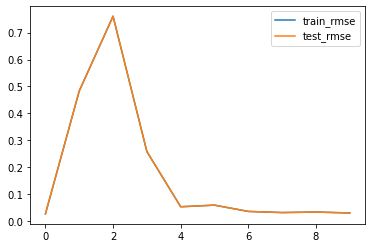

In [10]:
eva_train2, eva_test2 = model_train_test(net_2, 
                                   batchdata_fake, 
                                   batchdata_fake, 
                                   num_epochs =10)
num_epochs = 10
# 绘制图像，查看RMSE变化情况
plt.plot(list(range(num_epochs)), eva_train2[0], label='train_rmse')
plt.plot(list(range(num_epochs)), eva_test2[0], label='test_rmse')
plt.legend(loc = 1) #label摆放位置

In [16]:
eva_train2[0]

[0.026629842817783356,
 0.4832375943660736,
 0.7609087228775024,
 0.25812387466430664,
 0.053262218832969666,
 0.05921192839741707,
 0.03589961677789688,
 0.03165488317608833,
 0.0335928276181221,
 0.030157439410686493]

In [12]:
eva_train2[2]

[0.012474337592720985,
 0.3927692174911499,
 0.6593561768531799,
 0.2302348017692566,
 0.04063715040683746,
 0.0483488030731678,
 0.015982048586010933,
 0.013023781590163708,
 0.011721504852175713,
 0.01292162574827671]

In [13]:
eva_train2[3]

[0.9999996423721313,
 0.9998788237571716,
 0.999699592590332,
 0.9999654293060303,
 0.9999985098838806,
 0.999998152256012,
 0.9999993443489075,
 0.999999463558197,
 0.9999994039535522,
 0.9999995231628418]

In [11]:
#再训练real_data
starttime = datetime.datetime.now()

for i in range(150):
    fit_1(net_2, batchdata_train_real, epochs = 20)

endtime = datetime.datetime.now()
print(endtime - starttime)

tensor(763.8502, grad_fn=<MseLossBackward0>)
tensor(677.2764, grad_fn=<MseLossBackward0>)
tensor(671.5810, grad_fn=<MseLossBackward0>)
tensor(334.9278, grad_fn=<MseLossBackward0>)
tensor(397.8275, grad_fn=<MseLossBackward0>)
tensor(247.3244, grad_fn=<MseLossBackward0>)
tensor(193.4959, grad_fn=<MseLossBackward0>)
tensor(116.5312, grad_fn=<MseLossBackward0>)
tensor(101.6861, grad_fn=<MseLossBackward0>)
tensor(72.7116, grad_fn=<MseLossBackward0>)
tensor(57.6853, grad_fn=<MseLossBackward0>)
tensor(87.7321, grad_fn=<MseLossBackward0>)
tensor(88.4502, grad_fn=<MseLossBackward0>)
tensor(101.6743, grad_fn=<MseLossBackward0>)
tensor(62.3873, grad_fn=<MseLossBackward0>)
tensor(58.0555, grad_fn=<MseLossBackward0>)
tensor(84.5358, grad_fn=<MseLossBackward0>)
tensor(39.1448, grad_fn=<MseLossBackward0>)
tensor(75.5305, grad_fn=<MseLossBackward0>)
tensor(43.8818, grad_fn=<MseLossBackward0>)
tensor(45.8123, grad_fn=<MseLossBackward0>)
tensor(50.3221, grad_fn=<MseLossBackward0>)
tensor(58.6414, grad_f

tensor(33.0468, grad_fn=<MseLossBackward0>)
tensor(39.9747, grad_fn=<MseLossBackward0>)
tensor(30.1988, grad_fn=<MseLossBackward0>)
tensor(61.4421, grad_fn=<MseLossBackward0>)
tensor(39.6978, grad_fn=<MseLossBackward0>)
tensor(26.0410, grad_fn=<MseLossBackward0>)
tensor(56.9784, grad_fn=<MseLossBackward0>)
tensor(19.6276, grad_fn=<MseLossBackward0>)
tensor(51.3779, grad_fn=<MseLossBackward0>)
tensor(36.9217, grad_fn=<MseLossBackward0>)
tensor(31.6276, grad_fn=<MseLossBackward0>)
tensor(38.9157, grad_fn=<MseLossBackward0>)
tensor(34.2048, grad_fn=<MseLossBackward0>)
tensor(26.4857, grad_fn=<MseLossBackward0>)
tensor(33.4953, grad_fn=<MseLossBackward0>)
tensor(20.6955, grad_fn=<MseLossBackward0>)
tensor(55.2258, grad_fn=<MseLossBackward0>)
tensor(42.4319, grad_fn=<MseLossBackward0>)
tensor(28.1300, grad_fn=<MseLossBackward0>)
tensor(30.6897, grad_fn=<MseLossBackward0>)
tensor(32.2697, grad_fn=<MseLossBackward0>)
tensor(22.6631, grad_fn=<MseLossBackward0>)
tensor(52.6216, grad_fn=<MseLoss

tensor(23.6328, grad_fn=<MseLossBackward0>)
tensor(10.0083, grad_fn=<MseLossBackward0>)
tensor(55.9982, grad_fn=<MseLossBackward0>)
tensor(28.6770, grad_fn=<MseLossBackward0>)
tensor(18.5449, grad_fn=<MseLossBackward0>)
tensor(17.8385, grad_fn=<MseLossBackward0>)
tensor(15.5238, grad_fn=<MseLossBackward0>)
tensor(24.1359, grad_fn=<MseLossBackward0>)
tensor(15.1291, grad_fn=<MseLossBackward0>)
tensor(16.8493, grad_fn=<MseLossBackward0>)
tensor(25.8024, grad_fn=<MseLossBackward0>)
tensor(37.7293, grad_fn=<MseLossBackward0>)
tensor(24.2972, grad_fn=<MseLossBackward0>)
tensor(20.0157, grad_fn=<MseLossBackward0>)
tensor(13.7987, grad_fn=<MseLossBackward0>)
tensor(23.2751, grad_fn=<MseLossBackward0>)
tensor(31.2839, grad_fn=<MseLossBackward0>)
tensor(18.6165, grad_fn=<MseLossBackward0>)
tensor(19.7189, grad_fn=<MseLossBackward0>)
tensor(18.1113, grad_fn=<MseLossBackward0>)
tensor(12.2987, grad_fn=<MseLossBackward0>)
tensor(30.7000, grad_fn=<MseLossBackward0>)
tensor(24.6084, grad_fn=<MseLoss

tensor(8.2914, grad_fn=<MseLossBackward0>)
tensor(15.7971, grad_fn=<MseLossBackward0>)
tensor(16.1505, grad_fn=<MseLossBackward0>)
tensor(11.3290, grad_fn=<MseLossBackward0>)
tensor(6.5704, grad_fn=<MseLossBackward0>)
tensor(18.5545, grad_fn=<MseLossBackward0>)
tensor(26.8244, grad_fn=<MseLossBackward0>)
tensor(13.6809, grad_fn=<MseLossBackward0>)
tensor(21.2406, grad_fn=<MseLossBackward0>)
tensor(9.5308, grad_fn=<MseLossBackward0>)
tensor(8.8988, grad_fn=<MseLossBackward0>)
tensor(18.9714, grad_fn=<MseLossBackward0>)
tensor(12.8023, grad_fn=<MseLossBackward0>)
tensor(16.9585, grad_fn=<MseLossBackward0>)
tensor(15.8478, grad_fn=<MseLossBackward0>)
tensor(16.0386, grad_fn=<MseLossBackward0>)
tensor(19.8333, grad_fn=<MseLossBackward0>)
tensor(14.3253, grad_fn=<MseLossBackward0>)
tensor(15.0961, grad_fn=<MseLossBackward0>)
tensor(10.1082, grad_fn=<MseLossBackward0>)
tensor(14.2080, grad_fn=<MseLossBackward0>)
tensor(18.5065, grad_fn=<MseLossBackward0>)
tensor(14.8478, grad_fn=<MseLossBack

tensor(3.8701, grad_fn=<MseLossBackward0>)
tensor(1.8165, grad_fn=<MseLossBackward0>)
tensor(3.1449, grad_fn=<MseLossBackward0>)
tensor(2.0506, grad_fn=<MseLossBackward0>)
tensor(4.2985, grad_fn=<MseLossBackward0>)
tensor(4.5639, grad_fn=<MseLossBackward0>)
tensor(4.0806, grad_fn=<MseLossBackward0>)
tensor(3.4191, grad_fn=<MseLossBackward0>)
tensor(2.9431, grad_fn=<MseLossBackward0>)
tensor(1.3367, grad_fn=<MseLossBackward0>)
tensor(6.5959, grad_fn=<MseLossBackward0>)
tensor(3.0782, grad_fn=<MseLossBackward0>)
tensor(3.2341, grad_fn=<MseLossBackward0>)
tensor(1.4032, grad_fn=<MseLossBackward0>)
tensor(7.7790, grad_fn=<MseLossBackward0>)
tensor(3.2391, grad_fn=<MseLossBackward0>)
tensor(1.9047, grad_fn=<MseLossBackward0>)
tensor(3.5391, grad_fn=<MseLossBackward0>)
tensor(5.0816, grad_fn=<MseLossBackward0>)
tensor(3.1935, grad_fn=<MseLossBackward0>)
tensor(4.4361, grad_fn=<MseLossBackward0>)
tensor(1.9612, grad_fn=<MseLossBackward0>)
tensor(1.7538, grad_fn=<MseLossBackward0>)
tensor(1.84

tensor(0.9164, grad_fn=<MseLossBackward0>)
tensor(0.6551, grad_fn=<MseLossBackward0>)
tensor(0.4100, grad_fn=<MseLossBackward0>)
tensor(0.6496, grad_fn=<MseLossBackward0>)
tensor(0.6235, grad_fn=<MseLossBackward0>)
tensor(0.3453, grad_fn=<MseLossBackward0>)
tensor(0.4213, grad_fn=<MseLossBackward0>)
tensor(0.4973, grad_fn=<MseLossBackward0>)
tensor(0.5581, grad_fn=<MseLossBackward0>)
tensor(0.5654, grad_fn=<MseLossBackward0>)
tensor(0.3627, grad_fn=<MseLossBackward0>)
tensor(0.4276, grad_fn=<MseLossBackward0>)
tensor(0.3209, grad_fn=<MseLossBackward0>)
tensor(0.6163, grad_fn=<MseLossBackward0>)
tensor(0.2212, grad_fn=<MseLossBackward0>)
tensor(0.7966, grad_fn=<MseLossBackward0>)
tensor(3.1951, grad_fn=<MseLossBackward0>)
tensor(0.6292, grad_fn=<MseLossBackward0>)
tensor(0.7685, grad_fn=<MseLossBackward0>)
tensor(0.7590, grad_fn=<MseLossBackward0>)
tensor(0.1460, grad_fn=<MseLossBackward0>)
tensor(0.6547, grad_fn=<MseLossBackward0>)
tensor(0.7424, grad_fn=<MseLossBackward0>)
tensor(0.56

tensor(0.2258, grad_fn=<MseLossBackward0>)
tensor(0.0923, grad_fn=<MseLossBackward0>)
tensor(0.1277, grad_fn=<MseLossBackward0>)
tensor(0.1622, grad_fn=<MseLossBackward0>)
tensor(0.2802, grad_fn=<MseLossBackward0>)
tensor(0.8329, grad_fn=<MseLossBackward0>)
tensor(0.1419, grad_fn=<MseLossBackward0>)
tensor(0.0581, grad_fn=<MseLossBackward0>)
tensor(0.1898, grad_fn=<MseLossBackward0>)
tensor(0.2165, grad_fn=<MseLossBackward0>)
tensor(0.2034, grad_fn=<MseLossBackward0>)
tensor(0.3128, grad_fn=<MseLossBackward0>)
tensor(0.1074, grad_fn=<MseLossBackward0>)
tensor(0.1933, grad_fn=<MseLossBackward0>)
tensor(0.1808, grad_fn=<MseLossBackward0>)
tensor(2.8909, grad_fn=<MseLossBackward0>)
tensor(1.5743, grad_fn=<MseLossBackward0>)
tensor(0.2639, grad_fn=<MseLossBackward0>)
tensor(0.0871, grad_fn=<MseLossBackward0>)
tensor(0.1022, grad_fn=<MseLossBackward0>)
tensor(0.1711, grad_fn=<MseLossBackward0>)
tensor(0.1099, grad_fn=<MseLossBackward0>)
tensor(0.1745, grad_fn=<MseLossBackward0>)
tensor(0.13

tensor(1.8615, grad_fn=<MseLossBackward0>)
tensor(0.8682, grad_fn=<MseLossBackward0>)
tensor(0.1605, grad_fn=<MseLossBackward0>)
tensor(0.0767, grad_fn=<MseLossBackward0>)
tensor(0.1140, grad_fn=<MseLossBackward0>)
tensor(0.1212, grad_fn=<MseLossBackward0>)
tensor(0.1554, grad_fn=<MseLossBackward0>)
tensor(0.8351, grad_fn=<MseLossBackward0>)
tensor(0.1143, grad_fn=<MseLossBackward0>)
tensor(0.1653, grad_fn=<MseLossBackward0>)
tensor(0.1405, grad_fn=<MseLossBackward0>)
tensor(0.1655, grad_fn=<MseLossBackward0>)
tensor(0.0794, grad_fn=<MseLossBackward0>)
tensor(0.1859, grad_fn=<MseLossBackward0>)
tensor(0.1190, grad_fn=<MseLossBackward0>)
tensor(0.1189, grad_fn=<MseLossBackward0>)
tensor(0.1189, grad_fn=<MseLossBackward0>)
tensor(0.0846, grad_fn=<MseLossBackward0>)
tensor(0.0768, grad_fn=<MseLossBackward0>)
tensor(0.1381, grad_fn=<MseLossBackward0>)
tensor(4.5649, grad_fn=<MseLossBackward0>)
tensor(0.4160, grad_fn=<MseLossBackward0>)
tensor(0.1613, grad_fn=<MseLossBackward0>)
tensor(0.13

tensor(0.7649, grad_fn=<MseLossBackward0>)
tensor(4.3561, grad_fn=<MseLossBackward0>)
tensor(1.2429, grad_fn=<MseLossBackward0>)
tensor(0.4423, grad_fn=<MseLossBackward0>)
tensor(0.1665, grad_fn=<MseLossBackward0>)
tensor(0.1964, grad_fn=<MseLossBackward0>)
tensor(0.1410, grad_fn=<MseLossBackward0>)
tensor(0.2833, grad_fn=<MseLossBackward0>)
tensor(0.0981, grad_fn=<MseLossBackward0>)
tensor(0.0566, grad_fn=<MseLossBackward0>)
tensor(0.1036, grad_fn=<MseLossBackward0>)
tensor(0.1648, grad_fn=<MseLossBackward0>)
tensor(0.1055, grad_fn=<MseLossBackward0>)
tensor(0.1121, grad_fn=<MseLossBackward0>)
tensor(0.0971, grad_fn=<MseLossBackward0>)
tensor(0.1266, grad_fn=<MseLossBackward0>)
tensor(0.0686, grad_fn=<MseLossBackward0>)
tensor(0.0662, grad_fn=<MseLossBackward0>)
tensor(0.1051, grad_fn=<MseLossBackward0>)
tensor(0.1017, grad_fn=<MseLossBackward0>)
tensor(0.1059, grad_fn=<MseLossBackward0>)
tensor(3.9984, grad_fn=<MseLossBackward0>)
tensor(1.0545, grad_fn=<MseLossBackward0>)
tensor(0.23

tensor(0.0537, grad_fn=<MseLossBackward0>)
tensor(0.1221, grad_fn=<MseLossBackward0>)
tensor(0.1213, grad_fn=<MseLossBackward0>)
tensor(0.0788, grad_fn=<MseLossBackward0>)
tensor(0.1032, grad_fn=<MseLossBackward0>)
tensor(0.0874, grad_fn=<MseLossBackward0>)
tensor(0.0477, grad_fn=<MseLossBackward0>)
tensor(0.1506, grad_fn=<MseLossBackward0>)
tensor(3.4961, grad_fn=<MseLossBackward0>)
tensor(0.1313, grad_fn=<MseLossBackward0>)
tensor(0.2513, grad_fn=<MseLossBackward0>)
tensor(0.1194, grad_fn=<MseLossBackward0>)
tensor(0.1155, grad_fn=<MseLossBackward0>)
tensor(0.0886, grad_fn=<MseLossBackward0>)
tensor(0.1084, grad_fn=<MseLossBackward0>)
tensor(0.0926, grad_fn=<MseLossBackward0>)
tensor(0.1116, grad_fn=<MseLossBackward0>)
tensor(0.0709, grad_fn=<MseLossBackward0>)
tensor(0.0591, grad_fn=<MseLossBackward0>)
tensor(0.1144, grad_fn=<MseLossBackward0>)
tensor(0.0317, grad_fn=<MseLossBackward0>)
tensor(0.1052, grad_fn=<MseLossBackward0>)
tensor(0.0976, grad_fn=<MseLossBackward0>)
tensor(0.14

tensor(0.1090, grad_fn=<MseLossBackward0>)
tensor(0.0839, grad_fn=<MseLossBackward0>)
tensor(0.1505, grad_fn=<MseLossBackward0>)
tensor(0.1488, grad_fn=<MseLossBackward0>)
tensor(0.0674, grad_fn=<MseLossBackward0>)
tensor(0.0817, grad_fn=<MseLossBackward0>)
tensor(0.1271, grad_fn=<MseLossBackward0>)
tensor(0.0529, grad_fn=<MseLossBackward0>)
tensor(0.8213, grad_fn=<MseLossBackward0>)
tensor(0.5679, grad_fn=<MseLossBackward0>)
tensor(0.2041, grad_fn=<MseLossBackward0>)
tensor(0.1009, grad_fn=<MseLossBackward0>)
tensor(0.2584, grad_fn=<MseLossBackward0>)
tensor(0.1769, grad_fn=<MseLossBackward0>)
tensor(0.1150, grad_fn=<MseLossBackward0>)
tensor(0.2008, grad_fn=<MseLossBackward0>)
tensor(0.0166, grad_fn=<MseLossBackward0>)
tensor(0.1610, grad_fn=<MseLossBackward0>)
tensor(0.1940, grad_fn=<MseLossBackward0>)
tensor(0.0397, grad_fn=<MseLossBackward0>)
tensor(0.1631, grad_fn=<MseLossBackward0>)
tensor(0.0891, grad_fn=<MseLossBackward0>)
tensor(0.1378, grad_fn=<MseLossBackward0>)
tensor(0.14

tensor(0.0657, grad_fn=<MseLossBackward0>)
tensor(0.1118, grad_fn=<MseLossBackward0>)
tensor(0.0848, grad_fn=<MseLossBackward0>)
tensor(0.0748, grad_fn=<MseLossBackward0>)
tensor(0.0961, grad_fn=<MseLossBackward0>)
tensor(0.0327, grad_fn=<MseLossBackward0>)
tensor(0.1067, grad_fn=<MseLossBackward0>)
tensor(0.0522, grad_fn=<MseLossBackward0>)
tensor(0.1026, grad_fn=<MseLossBackward0>)
tensor(0.1556, grad_fn=<MseLossBackward0>)
tensor(0.1102, grad_fn=<MseLossBackward0>)
tensor(0.0807, grad_fn=<MseLossBackward0>)
tensor(0.0670, grad_fn=<MseLossBackward0>)
tensor(0.0612, grad_fn=<MseLossBackward0>)
tensor(0.0907, grad_fn=<MseLossBackward0>)
tensor(0.1242, grad_fn=<MseLossBackward0>)
tensor(7.2429, grad_fn=<MseLossBackward0>)
tensor(0.0853, grad_fn=<MseLossBackward0>)
tensor(0.2296, grad_fn=<MseLossBackward0>)
tensor(0.2363, grad_fn=<MseLossBackward0>)
tensor(0.1722, grad_fn=<MseLossBackward0>)
tensor(0.1054, grad_fn=<MseLossBackward0>)
tensor(0.1269, grad_fn=<MseLossBackward0>)
tensor(0.10

tensor(0.0934, grad_fn=<MseLossBackward0>)
tensor(0.1019, grad_fn=<MseLossBackward0>)
tensor(4.1386, grad_fn=<MseLossBackward0>)
tensor(0.1642, grad_fn=<MseLossBackward0>)
tensor(0.0791, grad_fn=<MseLossBackward0>)
tensor(0.1412, grad_fn=<MseLossBackward0>)
tensor(0.0664, grad_fn=<MseLossBackward0>)
tensor(0.0692, grad_fn=<MseLossBackward0>)
tensor(0.1391, grad_fn=<MseLossBackward0>)
tensor(0.0492, grad_fn=<MseLossBackward0>)
tensor(0.1057, grad_fn=<MseLossBackward0>)
tensor(0.0762, grad_fn=<MseLossBackward0>)
tensor(0.0581, grad_fn=<MseLossBackward0>)
tensor(0.1013, grad_fn=<MseLossBackward0>)
tensor(0.0803, grad_fn=<MseLossBackward0>)
tensor(0.1133, grad_fn=<MseLossBackward0>)
tensor(0.0966, grad_fn=<MseLossBackward0>)
tensor(0.1317, grad_fn=<MseLossBackward0>)
tensor(0.0747, grad_fn=<MseLossBackward0>)
tensor(0.1083, grad_fn=<MseLossBackward0>)
tensor(0.1372, grad_fn=<MseLossBackward0>)
tensor(0.1718, grad_fn=<MseLossBackward0>)
tensor(5.2131, grad_fn=<MseLossBackward0>)
tensor(0.09

tensor(0.0554, grad_fn=<MseLossBackward0>)
tensor(0.1085, grad_fn=<MseLossBackward0>)
tensor(0.1186, grad_fn=<MseLossBackward0>)
tensor(0.0648, grad_fn=<MseLossBackward0>)
tensor(0.1321, grad_fn=<MseLossBackward0>)
tensor(0.0951, grad_fn=<MseLossBackward0>)
tensor(0.0458, grad_fn=<MseLossBackward0>)
tensor(0.1024, grad_fn=<MseLossBackward0>)
tensor(0.1290, grad_fn=<MseLossBackward0>)
tensor(0.0459, grad_fn=<MseLossBackward0>)
tensor(0.1944, grad_fn=<MseLossBackward0>)
tensor(5.2894, grad_fn=<MseLossBackward0>)
tensor(0.1231, grad_fn=<MseLossBackward0>)
tensor(0.5116, grad_fn=<MseLossBackward0>)
tensor(0.1493, grad_fn=<MseLossBackward0>)
tensor(0.0814, grad_fn=<MseLossBackward0>)
tensor(0.1019, grad_fn=<MseLossBackward0>)
tensor(0.1431, grad_fn=<MseLossBackward0>)
tensor(0.0970, grad_fn=<MseLossBackward0>)
tensor(0.1229, grad_fn=<MseLossBackward0>)
tensor(0.0920, grad_fn=<MseLossBackward0>)
tensor(0.1117, grad_fn=<MseLossBackward0>)
tensor(0.0733, grad_fn=<MseLossBackward0>)
tensor(0.06

tensor(0.0824, grad_fn=<MseLossBackward0>)
tensor(0.1128, grad_fn=<MseLossBackward0>)
tensor(0.0603, grad_fn=<MseLossBackward0>)
tensor(0.1151, grad_fn=<MseLossBackward0>)
tensor(0.1000, grad_fn=<MseLossBackward0>)
tensor(0.1188, grad_fn=<MseLossBackward0>)
tensor(0.0589, grad_fn=<MseLossBackward0>)
tensor(0.1120, grad_fn=<MseLossBackward0>)
tensor(0.1445, grad_fn=<MseLossBackward0>)
tensor(0.1232, grad_fn=<MseLossBackward0>)
tensor(1.5403, grad_fn=<MseLossBackward0>)
tensor(1.5306, grad_fn=<MseLossBackward0>)
tensor(0.2770, grad_fn=<MseLossBackward0>)
tensor(0.0947, grad_fn=<MseLossBackward0>)
tensor(0.1223, grad_fn=<MseLossBackward0>)
tensor(0.1238, grad_fn=<MseLossBackward0>)
tensor(0.0495, grad_fn=<MseLossBackward0>)
tensor(0.0677, grad_fn=<MseLossBackward0>)
tensor(0.1058, grad_fn=<MseLossBackward0>)
tensor(0.1045, grad_fn=<MseLossBackward0>)
tensor(0.0519, grad_fn=<MseLossBackward0>)
tensor(0.0895, grad_fn=<MseLossBackward0>)
tensor(0.1282, grad_fn=<MseLossBackward0>)
tensor(0.07

tensor(0.3069, grad_fn=<MseLossBackward0>)
tensor(0.1903, grad_fn=<MseLossBackward0>)
tensor(0.0599, grad_fn=<MseLossBackward0>)
tensor(0.1287, grad_fn=<MseLossBackward0>)
tensor(0.1547, grad_fn=<MseLossBackward0>)
tensor(0.1387, grad_fn=<MseLossBackward0>)
tensor(0.0962, grad_fn=<MseLossBackward0>)
tensor(0.0840, grad_fn=<MseLossBackward0>)
tensor(0.1393, grad_fn=<MseLossBackward0>)
tensor(0.1311, grad_fn=<MseLossBackward0>)
tensor(0.2056, grad_fn=<MseLossBackward0>)
tensor(0.1394, grad_fn=<MseLossBackward0>)
tensor(0.0457, grad_fn=<MseLossBackward0>)
tensor(0.1936, grad_fn=<MseLossBackward0>)
tensor(0.2007, grad_fn=<MseLossBackward0>)
tensor(0.1186, grad_fn=<MseLossBackward0>)
tensor(0.0472, grad_fn=<MseLossBackward0>)
tensor(0.0702, grad_fn=<MseLossBackward0>)
tensor(3.0283, grad_fn=<MseLossBackward0>)
tensor(0.1721, grad_fn=<MseLossBackward0>)
tensor(0.2431, grad_fn=<MseLossBackward0>)
tensor(0.0404, grad_fn=<MseLossBackward0>)
tensor(0.0783, grad_fn=<MseLossBackward0>)
tensor(0.13

tensor(0.8750, grad_fn=<MseLossBackward0>)
tensor(4.0742, grad_fn=<MseLossBackward0>)
tensor(0.7713, grad_fn=<MseLossBackward0>)
tensor(4.5875, grad_fn=<MseLossBackward0>)
tensor(0.2495, grad_fn=<MseLossBackward0>)
tensor(0.1024, grad_fn=<MseLossBackward0>)
tensor(3.2814, grad_fn=<MseLossBackward0>)
tensor(1.8687, grad_fn=<MseLossBackward0>)
tensor(0.1539, grad_fn=<MseLossBackward0>)
tensor(0.0798, grad_fn=<MseLossBackward0>)
tensor(4.8036, grad_fn=<MseLossBackward0>)
tensor(0.0732, grad_fn=<MseLossBackward0>)
tensor(0.2565, grad_fn=<MseLossBackward0>)
tensor(0.1797, grad_fn=<MseLossBackward0>)
tensor(0.1298, grad_fn=<MseLossBackward0>)
tensor(1.5758, grad_fn=<MseLossBackward0>)
tensor(1.1566, grad_fn=<MseLossBackward0>)
tensor(0.1513, grad_fn=<MseLossBackward0>)
tensor(0.1759, grad_fn=<MseLossBackward0>)
tensor(0.0837, grad_fn=<MseLossBackward0>)
tensor(0.1330, grad_fn=<MseLossBackward0>)
tensor(2.1294, grad_fn=<MseLossBackward0>)
tensor(1.7435, grad_fn=<MseLossBackward0>)
tensor(0.75

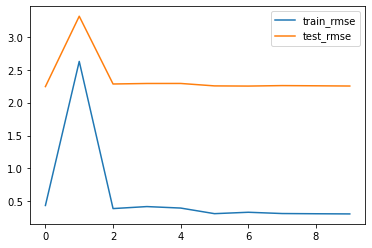

In [13]:
eva_train1, eva_test1= model_train_test(net_1, 
                                   batchdata_train_real, 
                                   batchdata_test_real, 
                                   num_epochs =10)
num_epochs = 10
# 绘制图像，查看RMSE变化情况
plt.plot(list(range(num_epochs)), eva_train1[0], label='train_rmse')
plt.plot(list(range(num_epochs)), eva_test1[0], label='test_rmse')
plt.legend(loc = 1) #label摆放位置

In [14]:
eva_train1[0]

[0.43629875779151917,
 2.626385450363159,
 0.38912343978881836,
 0.4196198284626007,
 0.39711320400238037,
 0.3119078576564789,
 0.3331897258758545,
 0.3138192296028137,
 0.3105556070804596,
 0.30802619457244873]

In [15]:
eva_test1[0]

[2.2438864707946777,
 3.313138246536255,
 2.2831850051879883,
 2.290987491607666,
 2.2913949489593506,
 2.254284381866455,
 2.251530170440674,
 2.258817672729492,
 2.2558350563049316,
 2.2523133754730225]

In [16]:
eva_test1[2]

[0.5475430488586426,
 2.593928098678589,
 0.4567452371120453,
 0.46708184480667114,
 0.4550037086009979,
 0.41365107893943787,
 0.4404434859752655,
 0.39516741037368774,
 0.39701852202415466,
 0.3989714980125427]

In [17]:
eva_test1[3]

[0.9973002672195435,
 0.9941142797470093,
 0.9972048401832581,
 0.9971857070922852,
 0.9971847534179688,
 0.997275173664093,
 0.9972818493843079,
 0.9972642064094543,
 0.9972714185714722,
 0.997279942035675]

tensor(4.4204, grad_fn=<MseLossBackward0>)
tensor(3.6539, grad_fn=<MseLossBackward0>)
tensor(0.3666, grad_fn=<MseLossBackward0>)
tensor(3.6050, grad_fn=<MseLossBackward0>)
tensor(1.0869, grad_fn=<MseLossBackward0>)
tensor(0.5044, grad_fn=<MseLossBackward0>)
tensor(3.9371, grad_fn=<MseLossBackward0>)
tensor(0.1042, grad_fn=<MseLossBackward0>)
tensor(0.0982, grad_fn=<MseLossBackward0>)
tensor(0.0628, grad_fn=<MseLossBackward0>)
tensor(5.7487, grad_fn=<MseLossBackward0>)
tensor(0.1569, grad_fn=<MseLossBackward0>)
tensor(0.0864, grad_fn=<MseLossBackward0>)
tensor(0.0399, grad_fn=<MseLossBackward0>)
tensor(0.0658, grad_fn=<MseLossBackward0>)
tensor(3.2509, grad_fn=<MseLossBackward0>)
tensor(0.7799, grad_fn=<MseLossBackward0>)
tensor(0.2965, grad_fn=<MseLossBackward0>)
tensor(0.1435, grad_fn=<MseLossBackward0>)
tensor(0.2447, grad_fn=<MseLossBackward0>)
tensor(0.0482, grad_fn=<MseLossBackward0>)
tensor(5.3368, grad_fn=<MseLossBackward0>)
tensor(1.0786, grad_fn=<MseLossBackward0>)
tensor(0.55

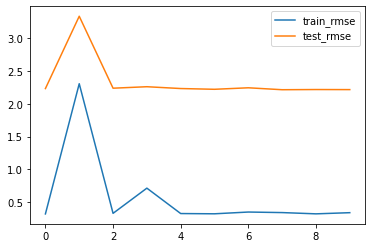

In [18]:
eva_train2, eva_test2 = model_train_test(net_2, 
                                   batchdata_train_real, 
                                   batchdata_test_real, 
                                   num_epochs =10)
num_epochs = 10
# 绘制图像，查看RMSE变化情况
plt.plot(list(range(num_epochs)), eva_train2[0], label='train_rmse')
plt.plot(list(range(num_epochs)), eva_test2[0], label='test_rmse')
plt.legend(loc = 1) #label摆放位置

In [19]:
eva_train2[0]

[0.3219016194343567,
 2.3058810234069824,
 0.3307690918445587,
 0.7145934104919434,
 0.32749441266059875,
 0.3237399160861969,
 0.35052233934402466,
 0.34225597977638245,
 0.32297205924987793,
 0.34072402119636536]

In [20]:
eva_test2[0]

[2.232100009918213,
 3.3341784477233887,
 2.2376644611358643,
 2.2601795196533203,
 2.2325408458709717,
 2.221057415008545,
 2.2438483238220215,
 2.2145049571990967,
 2.2173187732696533,
 2.2161998748779297]

In [21]:
eva_test2[2]

[0.4124746024608612,
 2.2420408725738525,
 0.41176319122314453,
 0.8205739855766296,
 0.4102426767349243,
 0.4289829730987549,
 0.41404715180397034,
 0.45363497734069824,
 0.4259943664073944,
 0.4559720754623413]

In [22]:
eva_test2[3]

[0.997328519821167,
 0.9940392971038818,
 0.9973152279853821,
 0.9972609281539917,
 0.9973275065422058,
 0.9973549246788025,
 0.9973003268241882,
 0.9973704814910889,
 0.997363805770874,
 0.9973664879798889]

In [17]:
def y_test(data_loader, net):
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    return y

def yhat_test(data_loader, net):
    data = data_loader.dataset                # 还原Dataset类
    X = data[:][0]                            # 还原数据的特征
    y = data[:][1]                            # 还原数据的标签
    yhat = net(X)
    return yhat

def test_data(model, 
              train_data,
              test_data,
              num_epochs = 10):
    y_test_list = []
    yhat_test_list = []
    for epochs in range(num_epochs):
        model.train()
        fit_1(net = model,
            batchdata = train_data, 
            epochs = epochs)
        model.eval()
        y_test_list.append(y_test(test_data, model))
        yhat_test_list.append(yhat_test(test_data, model))

    return y_test_list, yhat_test_list

In [24]:
y_test_list_1,yhat_test_list_1 = test_data(net_1, 
                            batchdata_train_real, 
                            batchdata_test_real, 
                            num_epochs = 10)

tensor(5.0300, grad_fn=<MseLossBackward0>)
tensor(5.1531, grad_fn=<MseLossBackward0>)
tensor(1.7368, grad_fn=<MseLossBackward0>)
tensor(4.0244, grad_fn=<MseLossBackward0>)
tensor(0.1286, grad_fn=<MseLossBackward0>)
tensor(0.1055, grad_fn=<MseLossBackward0>)
tensor(4.0828, grad_fn=<MseLossBackward0>)
tensor(1.0139, grad_fn=<MseLossBackward0>)
tensor(0.1092, grad_fn=<MseLossBackward0>)
tensor(0.1033, grad_fn=<MseLossBackward0>)
tensor(3.7344, grad_fn=<MseLossBackward0>)
tensor(0.4974, grad_fn=<MseLossBackward0>)
tensor(0.3678, grad_fn=<MseLossBackward0>)
tensor(0.2338, grad_fn=<MseLossBackward0>)
tensor(0.0714, grad_fn=<MseLossBackward0>)
tensor(4.0969, grad_fn=<MseLossBackward0>)
tensor(0.5482, grad_fn=<MseLossBackward0>)
tensor(0.4144, grad_fn=<MseLossBackward0>)
tensor(0.2114, grad_fn=<MseLossBackward0>)
tensor(0.1204, grad_fn=<MseLossBackward0>)
tensor(0.0577, grad_fn=<MseLossBackward0>)
tensor(6.2602, grad_fn=<MseLossBackward0>)
tensor(0.6987, grad_fn=<MseLossBackward0>)
tensor(0.29

In [25]:
test1 = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=y_test_list_1[-1].numpy().reshape(108,3))

test1.to_csv(r"C:\Users\Neos\Desktop\data_real.csv", encoding='gbk')

In [26]:
test2 = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=yhat_test_list_1[-1].detach().numpy().reshape(108,3))

test2.to_csv(r"C:\Users\Neos\Desktop\data_ELM.csv", encoding='gbk')

In [27]:
y_test_list_2,yhat_test_list_2 = test_data(net_2, 
                            batchdata_train_real, 
                            batchdata_test_real, 
                            num_epochs = 10)

tensor(1.0387, grad_fn=<MseLossBackward0>)
tensor(0.3999, grad_fn=<MseLossBackward0>)
tensor(0.1233, grad_fn=<MseLossBackward0>)
tensor(3.8300, grad_fn=<MseLossBackward0>)
tensor(0.1247, grad_fn=<MseLossBackward0>)
tensor(0.2363, grad_fn=<MseLossBackward0>)
tensor(4.2116, grad_fn=<MseLossBackward0>)
tensor(1.1015, grad_fn=<MseLossBackward0>)
tensor(1.0421, grad_fn=<MseLossBackward0>)
tensor(0.1605, grad_fn=<MseLossBackward0>)
tensor(6.1631, grad_fn=<MseLossBackward0>)
tensor(0.1078, grad_fn=<MseLossBackward0>)
tensor(0.2936, grad_fn=<MseLossBackward0>)
tensor(0.1621, grad_fn=<MseLossBackward0>)
tensor(0.0505, grad_fn=<MseLossBackward0>)
tensor(2.1039, grad_fn=<MseLossBackward0>)
tensor(2.4458, grad_fn=<MseLossBackward0>)
tensor(0.1615, grad_fn=<MseLossBackward0>)
tensor(0.0477, grad_fn=<MseLossBackward0>)
tensor(0.1235, grad_fn=<MseLossBackward0>)
tensor(0.0557, grad_fn=<MseLossBackward0>)
tensor(4.4357, grad_fn=<MseLossBackward0>)
tensor(0.2573, grad_fn=<MseLossBackward0>)
tensor(0.23

In [28]:
test3 = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=yhat_test_list_2[-1].detach().numpy().reshape(108,3))

test3.to_csv(r"C:\Users\Neos\Desktop\data_TL-ELM.csv", encoding='gbk')

In [18]:
y_test_list_fake,yhat_test_list_fake = test_data(net_2, 
                            batchdata_fake, 
                            batchdata_fake, 
                            num_epochs = 10)

tensor(3.4326, grad_fn=<MseLossBackward0>)
tensor(1.2804, grad_fn=<MseLossBackward0>)
tensor(0.0314, grad_fn=<MseLossBackward0>)
tensor(1.6736, grad_fn=<MseLossBackward0>)
tensor(0.2847, grad_fn=<MseLossBackward0>)
tensor(0.0446, grad_fn=<MseLossBackward0>)
tensor(0.3689, grad_fn=<MseLossBackward0>)
tensor(0.0126, grad_fn=<MseLossBackward0>)
tensor(0.0911, grad_fn=<MseLossBackward0>)
tensor(0.0009, grad_fn=<MseLossBackward0>)
tensor(3.9147, grad_fn=<MseLossBackward0>)
tensor(0.7085, grad_fn=<MseLossBackward0>)
tensor(0.0684, grad_fn=<MseLossBackward0>)
tensor(0.0056, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(3.1677, grad_fn=<MseLossBackward0>)
tensor(0.5710, grad_fn=<MseLossBackward0>)
tensor(0.1371, grad_fn=<MseLossBackward0>)
tensor(0.0049, grad_fn=<MseLossBackward0>)
tensor(0.0025, grad_fn=<MseLossBackward0>)
tensor(0.0044, grad_fn=<MseLossBackward0>)
tensor(2.1068, grad_fn=<MseLossBackward0>)
tensor(0.2404, grad_fn=<MseLossBackward0>)
tensor(0.05

In [23]:
test = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=y_test_list_fake[-1].detach().numpy().reshape(540,3))

test.to_csv(r"C:\Users\Neos\Desktop\data_real.csv", encoding='gbk')

In [24]:
testx = pd.DataFrame(columns=['整体升温', '线圈升温', '永磁体升温'], data=yhat_test_list_fake[-1].detach().numpy().reshape(540,3))

testx.to_csv(r"C:\Users\Neos\Desktop\data_ELM_fake.csv", encoding='gbk')